# <a id='toc1_'></a>[Analysis of the Error Propagation in Horns Algorithm](#toc0_)

In [2]:
import ipympl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform, linregress
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize
%matplotlib widget
%matplotlib inline

## <a id='toc1_1_'></a>[Introduction](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Analysis of the Error Propagation in Horns Algorithm](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Setting Up Functions](#toc1_2_)    
    - [Generating Sources](#toc1_2_1_)    
    - [Generating a the Fiducials in the CT Scan](#toc1_2_2_)    
    - [Horns Algorithm](#toc1_2_3_)    
  - [Analysis of Horns Algorithm](#toc1_3_)    
    - [Standard Deviation of RMSE](#toc1_3_1_)    
    - [Finding Relationship of Fiducial Distance from Origin](#toc1_3_2_)    
    - [STD Error Change with Number of Fiducials](#toc1_3_3_)    
- [Summary](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

The purpose of this notebook is to use a Monte Carlo simulation to find the Standard Deviation Error and Mean Error of horns algorithm given when the CT Points are perturbed by some amount (noise). Eventually we find a function that shows:
$$
\begin{align*}
f_{\text{Mean}}(R) &= \frac{\text{Mean of RMSE after Horns (R)}}{\text{Mean of RMSE of Noise}}\\
\quad\\
f_{\text{STD}}(R) &= \frac{\text{STD of RMSE after Horns (R)}}{\text{STD of RMSE of Noise}}
\end{align*}
$$
This gives us an estimate of how errors propagate through the system and how this propagation changes with the distance average $R$ of the fiducials from their centroid.

If you are interested in the results of this analysis you can skip over to the "Analysis of Horns Algorithm" Section

## <a id='toc1_2_'></a>[Setting Up Functions](#toc0_)

### <a id='toc1_2_1_'></a>[Generating Sources](#toc0_)

Throughout the rest of this notebook I will refer to the truth fiducials (real world) as **source** fiducials. 

To simulate the real life registration process I will evenly space n fiducials in the xy plane, along azimuthal direction. After which I will move each of the fiducials around a little (based on a normal distribution). This will simulate the bends in a person's back. 

Do note that normallly distributing in cylidrical form is not the same as perturbing in cartesian form. However, this should not affect the results too much as the reason for the perterbations is to prevent using the same sources over and over again, or have them lie in the same plane,

In [3]:
def generate_fiducials(fids, n, radius = 1, del_phi = np.pi / 16, del_theta = np.pi / 16, del_r = 0.1):
  """
  Generates a random set of fiducials in spherical coordinates, initiall are all in the xy plane, they are evenly spaced in the azimutal direction,
  and all at the same radius. The are then perturbed by a normal distribution, in each direction with the given standard deviations.
  fids: number of fiducials
  n: number of samples sets of fiducials
  radius: radius of the fiducials
  del_phi: standard deviation of the perturbation in the phi direction
  del_theta: standard deviation of the perturbation in the theta direction
  del_r: standard deviation of the perturbation in the radius direction
  returns: a numpy array of shape (n, fids, 3) with the fiducials
  """
  increments = np.linspace(np.pi / fids, (2 * fids - 1) * np.pi / fids, fids)
  theta = norm.rvs(size = (n, fids, 1), scale=del_theta)
  theta[:, :, 0] = theta[:, :, 0] + increments
  phi = norm.rvs(size = (n, fids, 1), scale=del_phi, loc  = np.pi /2)
  r = norm.rvs( size = (n, fids, 1), scale = del_r, loc = radius)
  points = np.concatenate([r, theta, phi], axis = 2)
  return points


In [4]:
def cylindrical_cartesian(point):
  """
  Converts a point in cylindrical coordinates to cartesian coordinates
  point: a numpy array of shape (3,) with the cylindrical coordinates
  returns: a numpy array of shape (3,) with the cartesian coordinates
  """
  out = point[0] * np.array([np.cos(point[1]) * np.sin(point[2]), np.sin(point[1]) * np.sin(point[2]), np.cos(point[2])])
  return out


In [5]:
a = [1, np.pi /3, np.pi /6]
b = cylindrical_cartesian(a)
b

array([0.25     , 0.4330127, 0.8660254])

In [6]:
fids = generate_fiducials(5, 10)
cart_fids = np.apply_along_axis(cylindrical_cartesian, 2, fids)
cart_fids.shape

(10, 5, 3)

Here I am testing the point generation by making a bunch of points and seeing where they are placed. They should form clumps of evenly space groups in the azimuthal direction.

(1000, 5, 3)


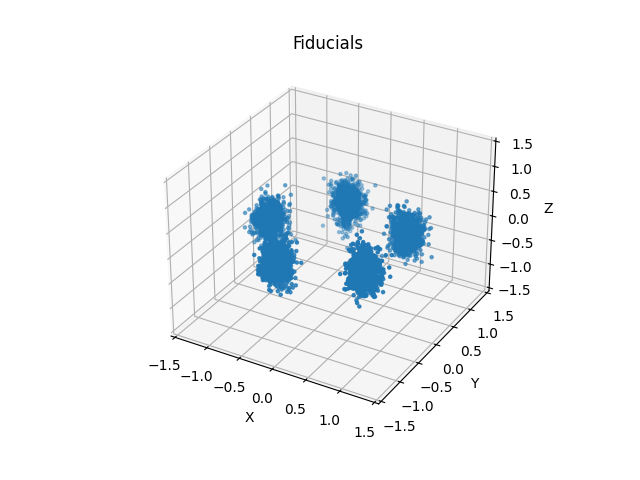

In [7]:
%matplotlib widget
fig = plt.figure(1)
fig.canvas.header_visible = False
# plt.title('Fiducials')
ax = fig.add_subplot(projection='3d')
n = 1000
fids = generate_fiducials(5, n, radius=1, del_r=0.1, del_theta = np.pi/32, del_phi = np.pi/16)
r, theta, phi = fids[:, :, 0], fids[:, :, 1], fids[:, :, 2]
cart_fids = np.apply_along_axis(cylindrical_cartesian, 2, fids)
print(cart_fids.shape)
x, y, z = cart_fids[:, :, 0], cart_fids[:, :, 1], cart_fids[:, :, 2]
ax.scatter(x, y, z, marker=".")
ax.set_title('Fiducials')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
# ax.set_visible(False)
plt.show()

In [8]:
plt.close()

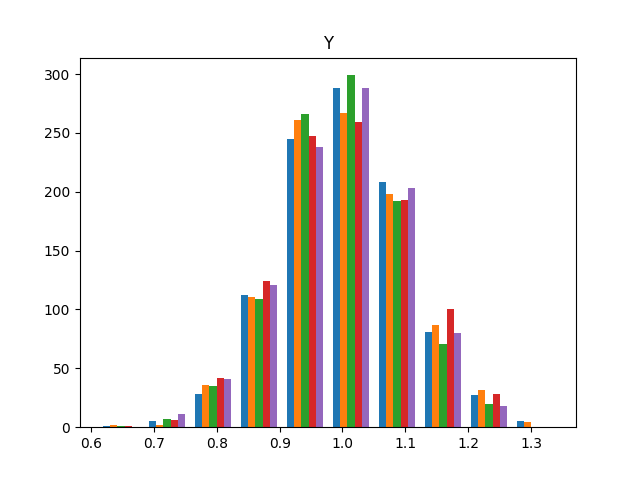

In [9]:
# print(y)
plt.figure()

plt.title("Y")
# plt.hist(y)
plt.hist(r);
# plt.figure()
# plt.title("Z")
# plt.hist(z)
# plt.figure()
# plt.title("X")
# plt.hist(x);

In [10]:
test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
test_cent = test.mean(axis = 1)
test_cent

array([2., 5., 8.])

### <a id='toc1_2_2_'></a>[Generating a the Fiducials in the CT Scan](#toc0_)

In this section I create "CT Fiducials" by randomly transforming the set of source points by a randomly distibuted rotation, scale and translation. After transforming them I add some random noise. This simulates errors in the registration process. 

In [11]:
def random_transform(bottom, top, normal = True):
    """
    Generate a random 3D vector from a uniform or normal distribution with the specified bounds
    :param bottom: The lower bound of the distribution. If normal is True, this is the 1st percentile, otherwise it is the minimum value
    :param top: The upper bound of the distribution. If normal is True, this is the 99th percentile, otherwise it is the maximum value
    :param normal: If True, the distribution is normal, otherwise it is uniform
    :return: A random 3D vector from the specified distribution
    """
    if normal:
        mean = (bottom + top) / 2  # Mean is the inverse of the CDF at the midpoint between the percentiles
        n_devs = (norm.ppf(0.99) - norm.ppf(0.01))
        std_dev = (top - bottom) / (n_devs)
        # print(f"Mean: {mean}, Std Dev: {std_dev}")
        return norm.rvs(size = 3, loc = mean, scale = std_dev)
    else:
        return uniform.rvs(size = 3, loc = bottom, scale = top - bottom)


In [12]:
def generate_other(source, translation, scale, rotation):
  """
  Generate a noised version of the source points
  :param source: The source points, shape = (fids, n, 3)
  :param translation: The translation vector
  :param scale: The scaling factor
  :param rotation: Euler angles for the rotation (degrees)
  :param noise: The noise level
  :return: The noised points
  """
  centroid = np.mean(source, axis=0)
  centroid = np.reshape(centroid, (1, 3))
  noised = source - centroid
  noised = noised * scale
  rotation_matrix = R.from_euler('xyz', rotation, degrees=True)
  noised = rotation_matrix.apply(noised)
  translation_reshaped = np.reshape(translation, (1, 3))
  noised = noised + translation_reshaped
  return noised

### <a id='toc1_2_3_'></a>[Horns Algorithm](#toc0_)
Source: [Registration Techniques in Robotics](https://roboticsknowledgebase.com/wiki/math/registration-techniques/)
Using the algoritm layed out above we take the noisy "CT Fiducials" and transform them to minimise the Root Mean Squared Error between the "CT Fiducials" and the "Source" fiducials.

In [13]:
def horns(source, noised):
  """
  Horn's method for point set registration
  :param source: The source points, shape = (n, 3)
  :param noised: The noised points, shape = (n, 3)
  :return: The scaling factor, rotation matrix, and translation vector
  """
  # print(f"Soure Shape: {source.shape}, Noised Shape: {noised.shape}")
  n = source.shape[0]
  source_centroid = np.mean(source, axis=0)
  noised_centroid = np.mean(noised, axis=0)
  source_shifted = source - source_centroid
  noised_shifted = noised - noised_centroid
  source_norm_sum = np.linalg.norm(source_shifted) ** 2
  noised_norm_sum = np.linalg.norm(noised_shifted) ** 2
  # print(f"Noised Norm Sum: {noised_norm_sum}, Source Norm Sum: {source_norm_sum}")
  s = np.sqrt(source_norm_sum / noised_norm_sum)
  # print(f"Source Shifted: {source_shifted.shape}, Noised Shifted: {noised_shifted.shape}")
  initial_guess = [0, 0, 0]
  def objective_function(params):
    """
    Objective function for the Horn's method
    :param params: The Euler angles for the rotation
    :return: The error value
    """
    rotation_matrix = R.from_euler('xyz', params, degrees=True)
    noised_rotated = rotation_matrix.apply(noised_shifted)
    zipped = list(zip(source_shifted, noised_rotated))
    mapped = list(map(lambda x: np.dot(x[0], x[1]), zipped))
    # print(f"Mapped: {list(mapped)}")
    subtractend = np.sum(mapped)
    # print(f"Subtractend: {subtractend}")
    return np.sqrt(noised_norm_sum * source_norm_sum) - subtractend


  euler_rotation = minimize(objective_function, initial_guess, method='Nelder-Mead')
  r = R.from_euler('xyz', euler_rotation.x, degrees=True)
  t = source_centroid - s*r.apply(noised_centroid)
  return (s, r, t)


def apply_transform(noised, s, r : R, t):
  """
  Apply the transformation to the noised points
  :param noised: The noised points, shape = (3)
  :param s: The scaling factor
  :param r: The rotation matrix
  :param t: The translation vector
  :return: The transformed points
  """
  return s * r.apply(noised) + t

Running it once to see that it works

Scale: 0.5, Rotation: [-39.70206629  -2.33719221 -28.65382666], Translation: [1.08826637 3.174638   1.37767709]


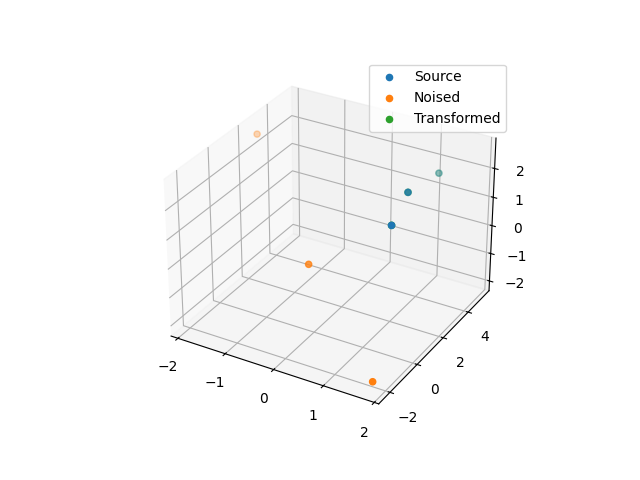

In [18]:
%matplotlib widget
# Test the Horn's method
N = 1
noise_dev = 0.0
source = generate_fiducials(3, N)
translation = random_transform(-1, 1)
rotation = random_transform(-40, 40, normal=False)
scale = norm.rvs(loc = 2, scale = 0)
# print(f"Scale: {scale}, Rotation: {rotation}, Translation: {translation}")
noised = []
added_noise = []
for fiducials in source:
        next = generate_other(fiducials, translation, scale, rotation)
        added = norm.rvs(size = next.shape, scale = noise_dev)
        noised.append(next + added)
noised = np.array(noised)
added_noise = np.array(added_noise)
s = []
r = []
t = []
for i in range(N):
        s_i, r_i, t_i = horns(source[i], noised[i])
        print(f"Scale: {s_i}, Rotation: {r_i.as_euler('xyz', degrees=True)}, Translation: {t_i}")
        s.append(s_i)
        r.append(r_i)
        t.append(t_i)
s = np.array(s)
r = np.array(r)
t = np.array(t)
noised_transformed = []
for i in range(N):
        noised_transformed.append(apply_transform(noised[i], s[i], r[i], t[i]))
noised_transformed = np.array(noised_transformed)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(source[0, :, 0], source[0, :, 1], source[0, :, 2], label='Source')
ax.scatter(noised[0, :, 0], noised[0, :, 1], noised[0, :, 2], label='Noised')
ax.scatter(noised_transformed[0, :, 0], noised_transformed[0, :, 1], noised_transformed[0, :, 2], label='Transformed')
ax.legend();

In [19]:
print(f'Original: {source}')
print(f'Scale: {s[0]}, Rotation: {r[0].as_euler("xyz", degrees=True)}, Translation: {t[0]}')
print(f'Target: {noised}')

Original: [[[1.16181421 1.4115198  1.36104564]
  [1.05294962 3.0252922  1.77816076]
  [1.11215146 5.19683711 1.60849993]]]
Scale: 0.5, Rotation: [-39.70206629  -2.33719221 -28.65382666], Translation: [1.08826637 3.174638   1.37767709]
Target: [[[ 1.81709887 -2.25784091 -2.01429712]
  [ 0.11384091 -0.73683354  0.42411228]
  [-1.87703118  2.40413162  2.69619372]]]


Here I make a function that we can use to run the simulation N times with different parameters

In [14]:
%matplotlib widget
def horns_test(fids = 4, n = 1, noise_dev = 0.1, translation_bounds = [-0.1, 0.1], rotation_bounds = [-np.pi / 8, np.pi / 8], scale_mean = 1, scale_dev = 0.1):
        """
        Test the Horn's method
        :param fids: The number of fiducials
        :param n: The number of sets of fiducials
        :param noise_dev: The standard deviation of the noise
        :param translation_bounds: The bounds for the translation vector, in terms of the [1st, 99th] percentiles
        :param rotation_bounds: The bounds for the rotation vector, in terms of the [1st, 99th] percentiles
        :param scale_mean: The mean of the scaling factor
        :param scale_dev: The standard deviation of the scaling factor
        :return: The source points, noised points, transformed noised points, scaling factors, rotation matrices, translation vectors, and added noise
        """
        # Test the Horn's method
        source = generate_fiducials(fids, n)
        translation = random_transform(translation_bounds[0], translation_bounds[1])
        rotation = random_transform(rotation_bounds[0], rotation_bounds[1], normal=False)
        scale = norm.rvs(loc = scale_mean, scale = scale_dev)
        # print(f"Scale: {scale}, Rotation: {rotation}, Translation: {translation}")
        noised = []
        added_noise = []
        for fiducials in source:
                next = generate_other(fiducials, translation, scale, rotation)
                added = norm.rvs(size = next.shape, scale = noise_dev)
                noised.append(next + added)
                added_noise.append(added)
        noised = np.array(noised)
        added_noise = np.array(added_noise)
        s = []
        r = []
        t = []
        for i in range(n):
                s_i, r_i, t_i = horns(source[i], noised[i])
                # print(f"Scale: {s_i}, Rotation: {r_i.as_euler('xyz', degrees=True)}, Translation: {t_i}")
                s.append(s_i)
                r.append(r_i)
                t.append(t_i)
        s = np.array(s)
        r = np.array(r)
        t = np.array(t)
        noised_transformed = []
        for i in range(n):
                noised_transformed.append(apply_transform(noised[i], s[i], r[i], t[i]))
        noised_transformed = np.array(noised_transformed)
        return (source, noised, noised_transformed, s, r, t, added_noise)

def horns_rmse_analysis(source, noised_transformed, added_noise):
        N = source.shape[0]
        fids = source.shape[1]
        rmse = []
        noise_rmse = []
        for i in range(N):
                next_rmse = np.linalg.norm(noised_transformed[i] - source[i]) / np.sqrt(fids)
                rmse.append(next_rmse)
                next_added_noise_rmse = np.linalg.norm(added_noise[i]) / np.sqrt(fids)
                noise_rmse.append(next_added_noise_rmse)
        return (rmse, noise_rmse)

## <a id='toc1_3_'></a>[Analysis of Horns Algorithm](#toc0_)

### <a id='toc1_3_1_'></a>[Standard Deviation of RMSE](#toc0_)
The most important goal of this notebook is to see how the noise between the two spaces affect the RMSE error in after horns algorithm has been used. Vitally, given an input noise with some standard deviation, what is standard deviation of after Horn's algorithm has been run. 

Mean Horns RMSE: 0.06024751655232526, Std Dev Horns RMSE: 0.014779191520091325
Mean Noise RMSE: 0.17077080882754606, Std Dev Noise RMSE: 0.030823801204000845


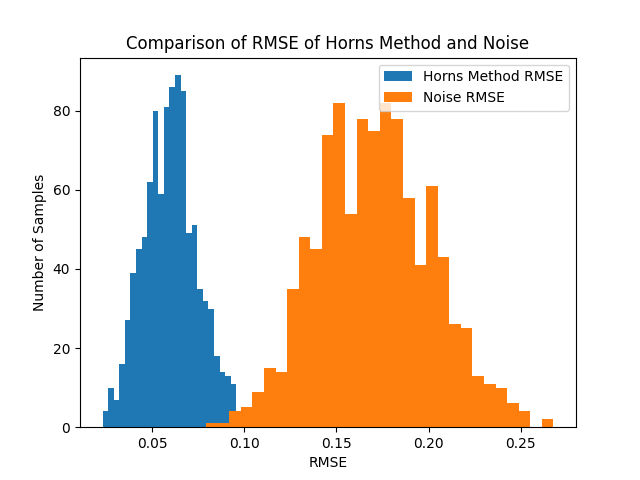

In [15]:
source, noised, noised_transformed, s, r, t, added_noise = horns_test(fids = 5, n = 1000, noise_dev = 0.1, scale_mean=2)
rmse, noise_rmse = horns_rmse_analysis(source, noised_transformed, added_noise)

fig = plt.figure()
plt.title("Comparison of RMSE of Horns Method and Noise")
plt.hist(rmse, bins = 30, label="Horns Method RMSE");
print(f"Mean Horns RMSE: {np.mean(rmse)}, Std Dev Horns RMSE: {np.std(rmse)}")
print(f"Mean Noise RMSE: {np.mean(noise_rmse)}, Std Dev Noise RMSE: {np.std(noise_rmse)}")
plt.hist(noise_rmse, bins = 30, label="Noise RMSE");
plt.xlabel("RMSE")
plt.ylabel("Number of Samples")
plt.legend();
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

Here we can see that, promisingly,  the total error between points is decreased by Horn's algorithm. More importantly the standard deviation also decreases. 

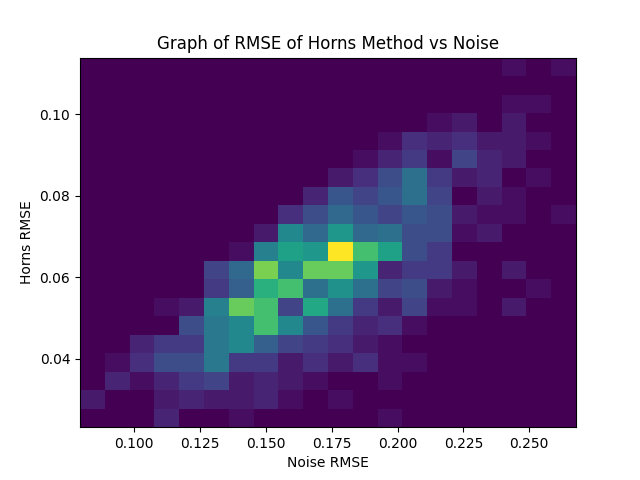

In [16]:
fig = plt.figure()
plt.title("Graph of RMSE of Horns Method vs Noise")
bins = plt.hist2d(noise_rmse, rmse, bins = 20);
plt.xlabel("Noise RMSE")
plt.ylabel("Horns RMSE");
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

By observing this data in a 2D histogram we can see there is an upper limit on the the error in horns algorithm given some rmse noise. This is great because it allows me to find the upper limit of the algorithms error.

(20, 20)
(21,)


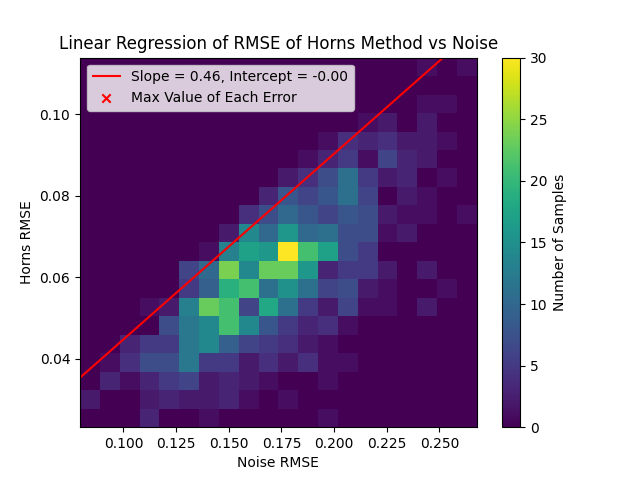

In [17]:
bin = bins[0]
i = []
ys = []
for x in range(bin.shape[0]):
        i.append(-1)
        ys.append(-1)
        for y in range(bin.shape[1]):
                # print(x, y)
                if bin[x, y] > 0:
                        # print(f"Bin: ({x}, {y}), Value: {bin[x, y]}")
                        i[x] = y
                        ys[x] = bins[2][y]
# print(i)
# print(ys)
xs = bins[1][: -1]
line = linregress(xs[:-2], ys[:-2])
# print(line)
plt.figure()
plt.title("Linear Regression of RMSE of Horns Method vs Noise")
plt.plot(xs, line[0] * xs + line[1], color='red', label="Slope = {:.2f}, Intercept = {:.2f}".format(line[0], line[1]))
print(bins[0].shape)
print(bins[2].shape)
plt.scatter(xs[:-2], ys[:-2], color='red', marker='x', label="Max Value of Each Error")
plt.legend()
bins = plt.hist2d(noise_rmse, rmse, bins = 20, label="2D Histogram");
plt.colorbar(label="Number of Samples")
plt.xlabel("Noise RMSE")
plt.ylabel("Horns RMSE");
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

This result means that when our upper bound on the error is about 0.4x that of our input noise

### <a id='toc1_3_2_'></a>[Finding Relationship of Fiducial Distance from Origin](#toc0_)

In [18]:
def run_horns_analysis(fids, n, scale_mean):
    source, noised, noised_transformed, s, r, t, added_noise = horns_test(fids = fids, n = n, noise_dev = 0.1, scale_mean=scale_mean)
    rmse, noise_rmse = horns_rmse_analysis(source, noised_transformed, added_noise)
    return (np.mean(rmse), np.std(rmse), np.mean(noise_rmse), np.std(noise_rmse))

In [19]:
np.random.seed(0)
fids = 5
n = 100 
scale_mean = np.linspace(1, 4, 20)
results = []
for mean in scale_mean:
    results.append(run_horns_analysis(fids, n, mean))
results = np.array(results)

Slope: -0.430551039464279, Intercept: -3.235199971744396


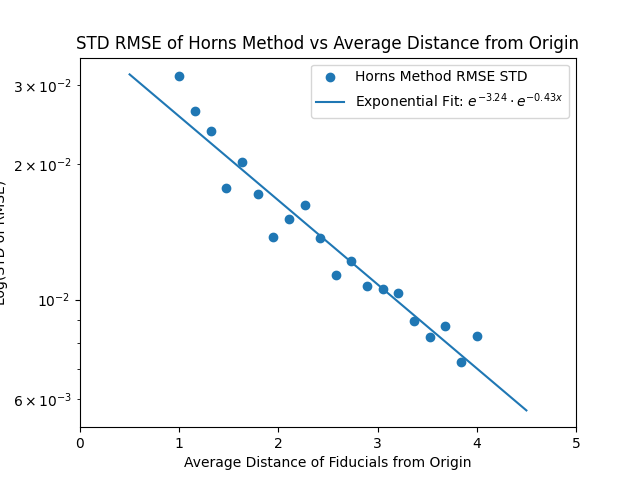

In [20]:
x = np.linspace(0.5, 4.5, 10)
y = results[:, 1]
log_y = np.log(y)
regress = linregress(scale_mean, log_y)
slope, intercept = regress.slope, regress.intercept
print(f"Slope: {slope}, Intercept: {intercept}")
fitted = np.exp(slope * x + intercept)
fig = plt.figure()
plt.title("STD RMSE of Horns Method vs Average Distance from Origin")
plt.scatter(scale_mean, y, label="Horns Method RMSE STD")
plt.plot(x, fitted, label=f"Exponential Fit: $e ^{{ {intercept:.2f} }} \\cdot e ^{{{slope:.2f}x}}$")
plt.xlabel("Average Distance of Fiducials from Origin")
plt.ylabel("Log(STD of RMSE)")
plt.legend()
plt.yscale('log')
plt.xlim(0, 5)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

The STD of error decreases exponentially with distance

Slope: -0.4378452305651453, Intercept: -1.855336725093889


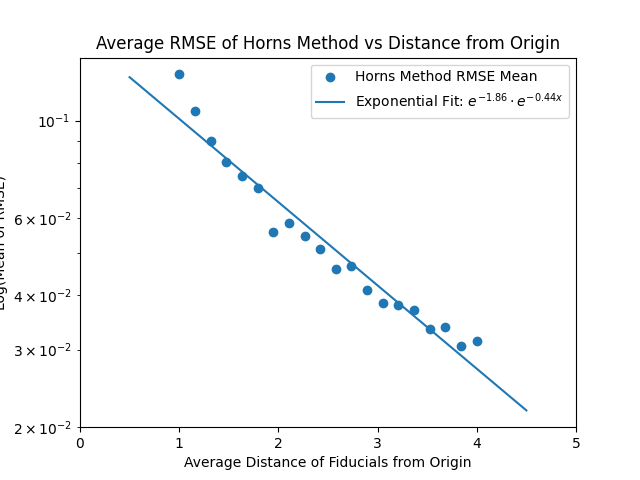

In [23]:
x = np.linspace(0.5, 4.5, 10)
y = results[:, 0]
log_y = np.log(y)
regress = linregress(scale_mean, log_y)
slope, intercept = regress.slope, regress.intercept
print(f"Slope: {slope}, Intercept: {intercept}")
fitted = np.exp(slope * x + intercept)
fig = plt.figure()
plt.title("Average RMSE of Horns Method vs Distance from Origin")
plt.scatter(scale_mean, y, label="Horns Method RMSE Mean")
plt.plot(x, fitted, label=f"Exponential Fit: $e ^{{ {intercept:.2f} }} \\cdot e ^{{{slope:.2f}x}}$")
plt.xlabel("Average Distance of Fiducials from Origin")
plt.ylabel("Log(Mean of RMSE)")
plt.legend()
plt.yscale('log')
plt.xlim(0, 5)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

In [24]:
plt.close()

We can find the fraction of mean and std from noise and horns now wrt distance:
$$
\begin{align*}
f_{\text{Mean}}(R) &= \frac{\text{Mean of RMSE after Horns (R)}}{\text{Mean of RMSE of Noise}}\\
\quad\\
f_{\text{STD}}(R) &= \frac{\text{STD of RMSE after Horns (R)}}{\text{STD of RMSE of Noise}}
\end{align*}
$$
Mean of RMSE of Noise 0.16894519741400524, STD of RMSE of Noise: 0.03223433908010328

Horns RMSE Mean - Slope: -0.4378452305651453, Intercept: -1.855336725093889

Horns RMSE STD - Slope: -0.430551039464279, Intercept: -3.235199971744396

Therefore:
$$
\begin{align*}
\log(f_{\text{Mean}}(R)) &= -0.438 \cdot R - 2.02
\quad\\
\log(f_{\text{STD}}(R)) &= -0.431 \cdot R -3.2
\end{align*}
$$


### <a id='toc1_3_3_'></a>[STD Error Change with Number of Fiducials](#toc0_)

In [25]:
n_fids = np.arange(3, 15)
n = 200
scale_mean = 2
results = []
for fids in n_fids:
    results.append(run_horns_analysis(fids, n, scale_mean))
results = np.array(results)

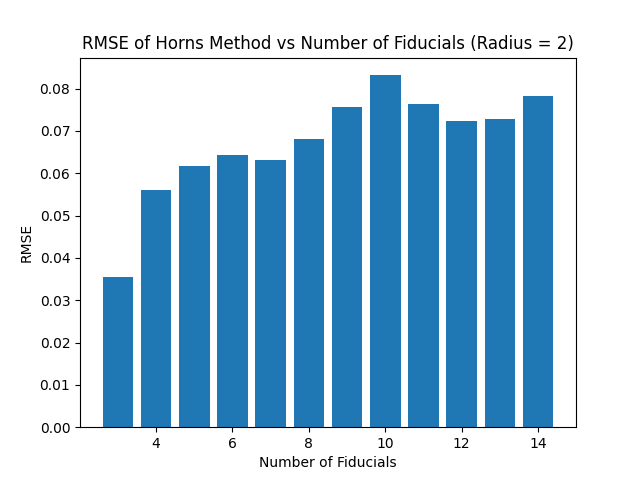

In [26]:
y = results[:, 0]
fig = plt.figure()
plt.title("RMSE of Horns Method vs Number of Fiducials (Radius = 2)")
plt.xlabel("Number of Fiducials")
plt.ylabel("RMSE")
plt.bar(n_fids, y)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

Interestingly the total error does increase with the number of fiducials. This may be a sign of a bug in the code. 

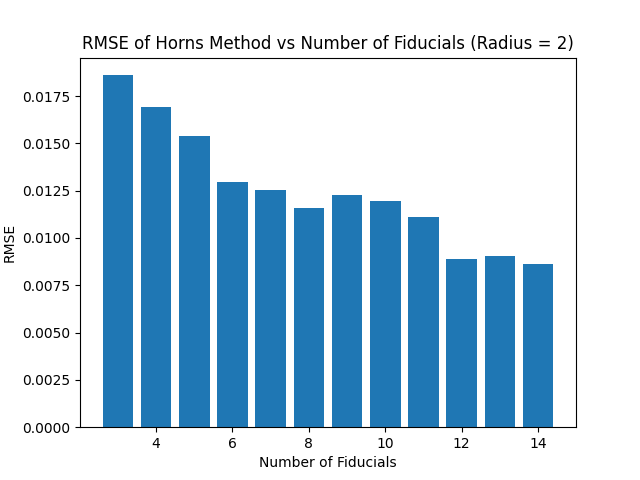

In [27]:
y = results[:, 1]
fig = plt.figure()
plt.title("RMSE of Horns Method vs Number of Fiducials (Radius = 2)")
plt.xlabel("Number of Fiducials")
plt.ylabel("RMSE")
plt.bar(n_fids, y)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

Although the number of fiducials does increase precision there are diminishing returns as the number gets higher.

# <a id='toc2_'></a>[Summary](#toc0_)
Where:
$$
\begin{align*}
f_{\text{Mean}}(R) &= \frac{\text{Mean of RMSE after Horns (R)}}{\text{Mean of RMSE of Noise}}\\
\quad\\
f_{\text{STD}}(R) &= \frac{\text{STD of RMSE after Horns (R)}}{\text{STD of RMSE of Noise}}
\end{align*}
$$
We have:
$$
\begin{align*}
\log(f_{\text{Mean}}(R)) &= -0.438 \cdot R - 2.02
\quad\\
\log(f_{\text{STD}}(R)) &= -0.431 \cdot R -3.2
\end{align*}
$$


The number of fiducials might increase the mean total error, but they will increase the precision as well